In [72]:
import warnings
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from dotenv import load_dotenv
from omegaconf import OmegaConf
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformer_lens import HookedTransformer, HookedTransformerConfig

sys.path.append(f'{os.getcwd()}/../')
from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from utils import heatmap_uncertainty

from metrics import (
    EM_compute,
    has_answer, # InAcc
    F1_compute,
)
load_dotenv()

True

In [73]:
nq_dataset = pd.read_csv('../data/adaptive_rag_natural_questions.csv')
wiki_dataset = pd.read_csv('../data/adaptive_rag_2wikimultihopqa.csv')
hotpot_dataset = pd.read_csv('../data/adaptive_rag_hotpotqa.csv')
musique_dataset = pd.read_csv('../data/adaptive_rag_musique.csv')

nq_dataset_test = pd.read_csv('../data/adaptive_rag_natural_questions_test.csv')
wiki_dataset_test = pd.read_csv('../data/adaptive_rag_2wikimultihopqa_test.csv')
hotpot_dataset_test = pd.read_csv('../data/adaptive_rag_hotpotqa_test.csv')
musique_dataset_test = pd.read_csv('../data/adaptive_rag_musique_test.csv')

In [3]:
ds = pd.concat([nq_dataset, wiki_dataset, hotpot_dataset, musique_dataset, 
    nq_dataset_test, wiki_dataset_test, hotpot_dataset_test, musique_dataset_test])
ds = ds.reset_index(drop=True)

train_indices, test_indices = train_test_split(list(ds.index), test_size=0.2, random_state=42)

In [4]:
preds_df = ds.iloc[test_indices].reset_index(drop=True)

In [5]:
cfg = OmegaConf.load("../config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

## QA Metrics

In [21]:
rag_calls = {
    'Never RAG': 0, 
    'Always RAG': preds_df.shape[0]
}

def call_rag(preds_df, preds, method_name, rag_calls):
    answers = []
    for index, pred_class in tqdm(enumerate(preds)):
        
        if pred_class == 0: # call rag and get context
            final_answer = preds_df.iloc[index]['our_answer_w_context']
        else: # answer is correct, do not call rag
            final_answer = preds_df.iloc[index]['our_answer_wo_context']

        answers.append(final_answer)
        
    preds_df[method_name] = answers
    rag_calls[method_name] = list(preds).count(0)
    
    return preds_df

# hook_resid_post 28 layer Logits 

In [74]:
def store_activations(activation_dict):
    def hook_fn(activation, hook):
        activation_dict[hook.name] = activation.detach()
    return hook_fn

In [75]:
X = torch.empty((ds.shape[0], 3072), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0
activation_store = {}

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        # (1, seq_len, vocab_size)
        logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store)) 
                for i in range(model.cfg.n_layers)],
        )
    resid = activation_store[f"blocks.{27}.hook_resid_post"] # last hidden_state before lm head (1, seq_len, hidden_size)
    final_logits = resid[:, -1, :].squeeze(dim=0) # (vocab_size)

    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [04:37<00:00, 14.40it/s]


In [76]:
print(X.shape)
print(y.shape)

torch.Size([4000, 3072])
torch.Size([4000])


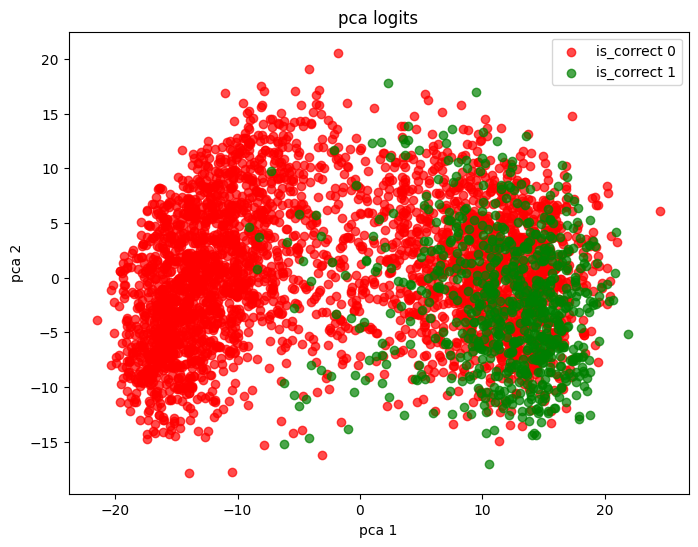

In [10]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

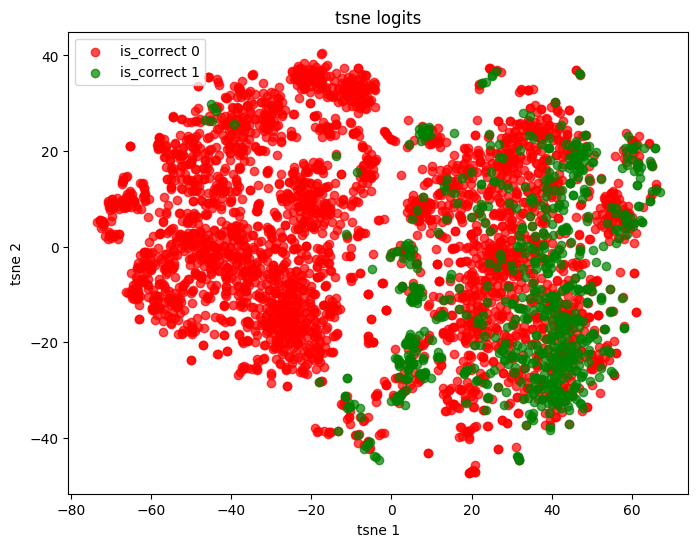

In [11]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## Unbalanced data + LogisticRegression

In [15]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [16]:
def y_proportion(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    total_elements = tensor.numel()
    proportions = counts.float() / total_elements
    return proportions

print(y_proportion(y))
print(y_proportion(y_train))
print(y_proportion(y_test))

tensor([0.8240, 0.1760])
tensor([0.8272, 0.1728])
tensor([0.8112, 0.1887])


In [17]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       649
           1       0.56      0.54      0.55       151

    accuracy                           0.83       800
   macro avg       0.73      0.72      0.73       800
weighted avg       0.83      0.83      0.83       800



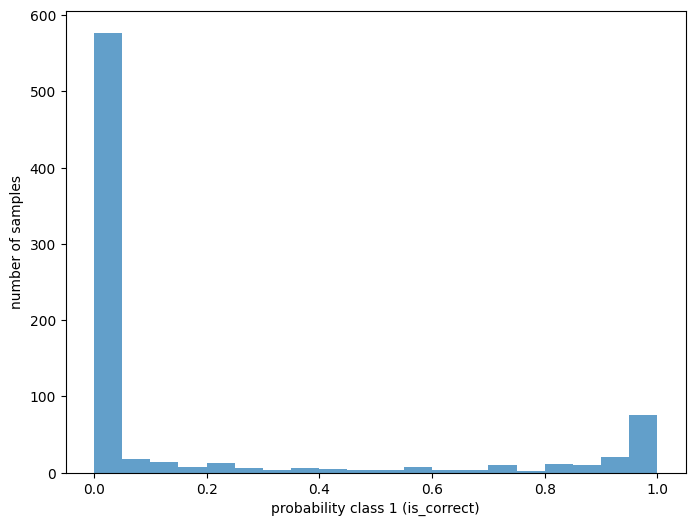

In [19]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [22]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_28_layer_resid_post_logits', rag_calls)

800it [00:00, 24402.87it/s]


## Downsampling + LogisticRegression

In [24]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

downsampled_class_0_indices = np.random.choice(class_0_indices, size=int(len(class_1_indices)*1.5), replace=False)
balanced_indices = np.concatenate([downsampled_class_0_indices, class_1_indices])
np.random.shuffle(balanced_indices)

X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [25]:
print('Before')
print(f'Num samples in train: {y_train.shape[0]}')
print(f'Distribution: {y_proportion(y_train)}')

print('After')
print(f'Num samples in train: {y_train_balanced.shape[0]}')
print(y_proportion(y_train_balanced))

Before
Num samples in train: 3200
Distribution: tensor([0.8272, 0.1728])
After
Num samples in train: 1382
tensor([0.5999, 0.4001])


In [26]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       649
           1       0.47      0.77      0.58       151

    accuracy                           0.79       800
   macro avg       0.70      0.78      0.72       800
weighted avg       0.85      0.79      0.81       800



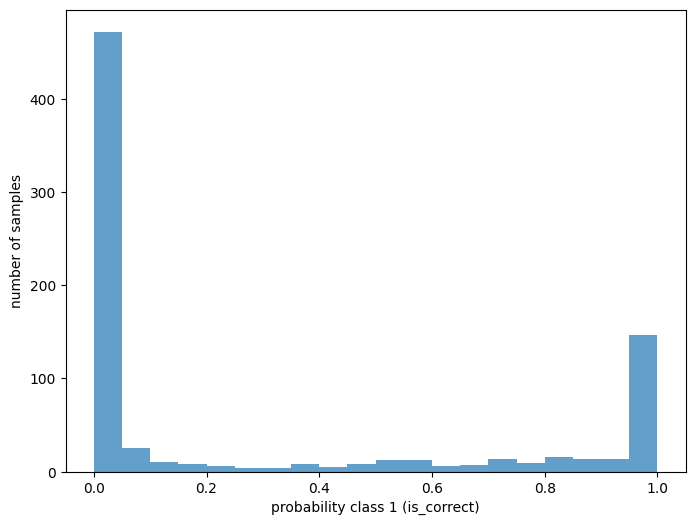

In [28]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [29]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_downsampling_28_layer_resid_post_logits', rag_calls)

800it [00:00, 22968.01it/s]


## MLP + bce + unbalanced data

In [30]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [31]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

y_train = y_train.float()
y_test = y_test.float()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{30}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4048
Epoch 2/30, Loss: 0.2947
Epoch 3/30, Loss: 0.2739
Epoch 4/30, Loss: 0.2573
Epoch 5/30, Loss: 0.2437
Epoch 6/30, Loss: 0.2279
Epoch 7/30, Loss: 0.2084
Epoch 8/30, Loss: 0.1926
Epoch 9/30, Loss: 0.1725
Epoch 10/30, Loss: 0.1503
Epoch 11/30, Loss: 0.1252
Epoch 12/30, Loss: 0.1030
Epoch 13/30, Loss: 0.0979
Epoch 14/30, Loss: 0.0718
Epoch 15/30, Loss: 0.0566
Epoch 16/30, Loss: 0.0413
Epoch 17/30, Loss: 0.0324
Epoch 18/30, Loss: 0.0237
Epoch 19/30, Loss: 0.0168
Epoch 20/30, Loss: 0.0121
Epoch 21/30, Loss: 0.0093
Epoch 22/30, Loss: 0.0074
Epoch 23/30, Loss: 0.0061
Epoch 24/30, Loss: 0.0050
Epoch 25/30, Loss: 0.0042
Epoch 26/30, Loss: 0.0035
Epoch 27/30, Loss: 0.0030
Epoch 28/30, Loss: 0.0026
Epoch 29/30, Loss: 0.0025
Epoch 30/30, Loss: 0.0022


In [32]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0.5).astype(int)

print(classification_report(y_test.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90       649
         1.0       0.60      0.54      0.56       151

    accuracy                           0.84       800
   macro avg       0.75      0.73      0.73       800
weighted avg       0.84      0.84      0.84       800



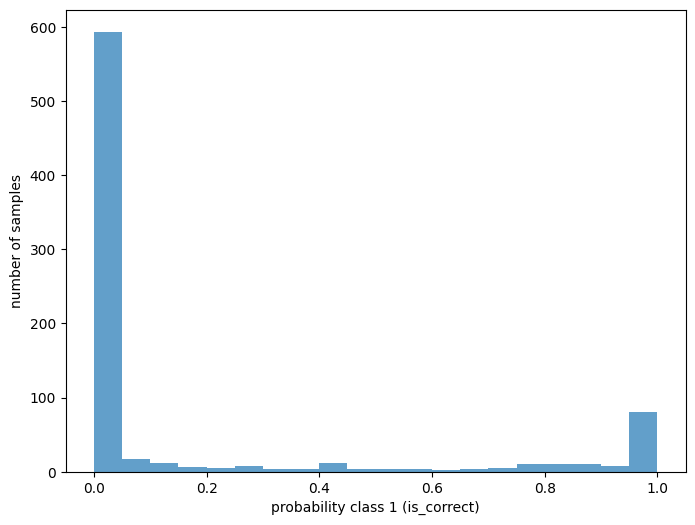

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(logits_test, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [34]:
preds_df = call_rag(preds_df, y_pred, 'mlp_28_layer_resid_post_logits', rag_calls)

800it [00:00, 21758.78it/s]


## Hinge Loss MLP + unbalanced data

In [35]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [36]:
y_train_hinge = y_train * 2 - 1  # 0 -> -1, 1 -> 1
y_test_hinge = y_test * 2 - 1

train_dataset = TensorDataset(X_train, y_train_hinge)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.MarginRankingLoss(margin=1.0)
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X).squeeze()
        loss = criterion(logits, torch.zeros_like(logits), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/30, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4423
Epoch 2/30, Loss: 0.3461
Epoch 3/30, Loss: 0.3248
Epoch 4/30, Loss: 0.2968
Epoch 5/30, Loss: 0.2745
Epoch 6/30, Loss: 0.2620
Epoch 7/30, Loss: 0.2448
Epoch 8/30, Loss: 0.2321
Epoch 9/30, Loss: 0.2108
Epoch 10/30, Loss: 0.1899
Epoch 11/30, Loss: 0.1639
Epoch 12/30, Loss: 0.1452
Epoch 13/30, Loss: 0.1300
Epoch 14/30, Loss: 0.1073
Epoch 15/30, Loss: 0.0877
Epoch 16/30, Loss: 0.0721
Epoch 17/30, Loss: 0.0518
Epoch 18/30, Loss: 0.0386
Epoch 19/30, Loss: 0.0354
Epoch 20/30, Loss: 0.0309
Epoch 21/30, Loss: 0.0232
Epoch 22/30, Loss: 0.0186
Epoch 23/30, Loss: 0.0151
Epoch 24/30, Loss: 0.0096
Epoch 25/30, Loss: 0.0069
Epoch 26/30, Loss: 0.0052
Epoch 27/30, Loss: 0.0040
Epoch 28/30, Loss: 0.0022
Epoch 29/30, Loss: 0.0017
Epoch 30/30, Loss: 0.0023


In [37]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       649
         1.0       0.58      0.63      0.60       151

    accuracy                           0.84       800
   macro avg       0.75      0.76      0.75       800
weighted avg       0.85      0.84      0.85       800



In [38]:
preds_df = call_rag(preds_df, y_pred, 'mlp_hinge_loss_28_layer_resid_post_logits', rag_calls)

800it [00:00, 21721.03it/s]


## Weighted cross entropy MLP + unbalanced data

In [77]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [78]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [79]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [82]:
mlp = MLP().to(device)

class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

In [83]:
for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/30, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4779
Epoch 2/30, Loss: 0.3810
Epoch 3/30, Loss: 0.3460
Epoch 4/30, Loss: 0.3207
Epoch 5/30, Loss: 0.2975
Epoch 6/30, Loss: 0.2674
Epoch 7/30, Loss: 0.2412
Epoch 8/30, Loss: 0.2109
Epoch 9/30, Loss: 0.1946
Epoch 10/30, Loss: 0.1494
Epoch 11/30, Loss: 0.1239
Epoch 12/30, Loss: 0.1092
Epoch 13/30, Loss: 0.0829
Epoch 14/30, Loss: 0.0694
Epoch 15/30, Loss: 0.0596
Epoch 16/30, Loss: 0.0402
Epoch 17/30, Loss: 0.0287
Epoch 18/30, Loss: 0.0223
Epoch 19/30, Loss: 0.0152
Epoch 20/30, Loss: 0.0110
Epoch 21/30, Loss: 0.0080
Epoch 22/30, Loss: 0.0068
Epoch 23/30, Loss: 0.0052
Epoch 24/30, Loss: 0.0046
Epoch 25/30, Loss: 0.0040
Epoch 26/30, Loss: 0.0031
Epoch 27/30, Loss: 0.0025
Epoch 28/30, Loss: 0.0022
Epoch 29/30, Loss: 0.0020
Epoch 30/30, Loss: 0.0019


In [84]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device))
    y_pred = torch.argmax(logits_test, dim=1).cpu().numpy()

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       649
           1       0.62      0.54      0.58       151

    accuracy                           0.85       800
   macro avg       0.76      0.73      0.74       800
weighted avg       0.84      0.85      0.85       800



In [85]:
preds_df = call_rag(preds_df, y_pred, 'mlp_weighted_bce_loss_28_layer_resid_post_logits', rag_calls)

800it [00:00, 19986.44it/s]


## Catboost on logits

In [42]:
from catboost import CatBoostClassifier

In [43]:
pca = PCA(n_components=512)
X_reduced = pca.fit_transform(X)
X_reduced_train = X_reduced[train_indices]
X_reduced_test = X_reduced[test_indices]

clf = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='CrossEntropy',
    verbose=100,
    task_type="GPU"
)

In [44]:
clf.fit(X_reduced_train, y_train.numpy(), eval_set=(X_reduced_test, y_test.numpy()), early_stopping_rounds=50)

TBB Warning: The number of workers is currently limited to 9. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6457706	test: 0.6498544	best: 0.6498544 (0)	total: 34.7ms	remaining: 34.7s
100:	learn: 0.2205882	test: 0.3165593	best: 0.3165593 (100)	total: 2.96s	remaining: 26.3s
200:	learn: 0.1669229	test: 0.3066279	best: 0.3065899 (191)	total: 5.98s	remaining: 23.8s
300:	learn: 0.1303312	test: 0.3050940	best: 0.3045464 (294)	total: 8.86s	remaining: 20.6s
bestTest = 0.3045463943
bestIteration = 294
Shrink model to first 295 iterations.


In [45]:
y_pred = clf.predict(X_reduced_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       649
         1.0       0.67      0.39      0.49       151

    accuracy                           0.85       800
   macro avg       0.77      0.67      0.70       800
weighted avg       0.83      0.85      0.83       800



In [46]:
preds_df = call_rag(preds_df, y_pred, 'catboost_28_layer_resid_post_logits', rag_calls)

800it [00:00, 21780.39it/s]


# Logits from head

In [47]:
X = torch.empty((ds.shape[0], 128256), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        logits = model(tokens)  # (1, seq_len, vocab_size)
    
    final_logits = logits[:, -1, :].squeeze(dim=0) # (vocab_size)
    
    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [04:53<00:00, 13.62it/s]


In [48]:
print(X.shape)
print(y.shape)

torch.Size([4000, 128256])
torch.Size([4000])


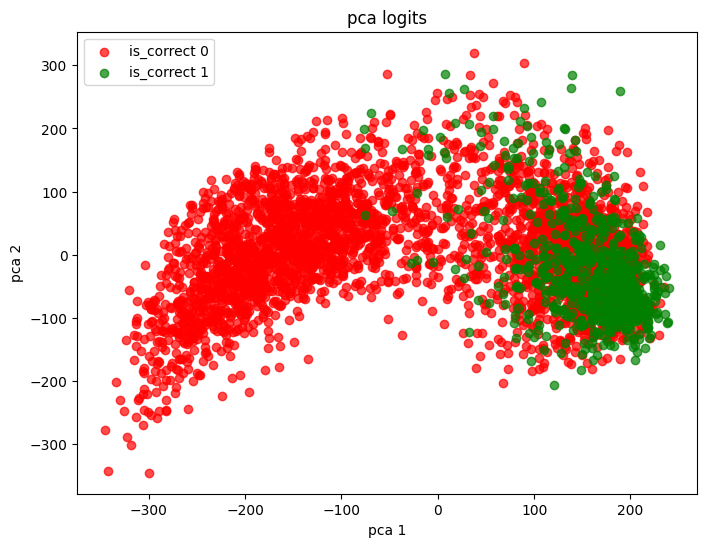

In [49]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

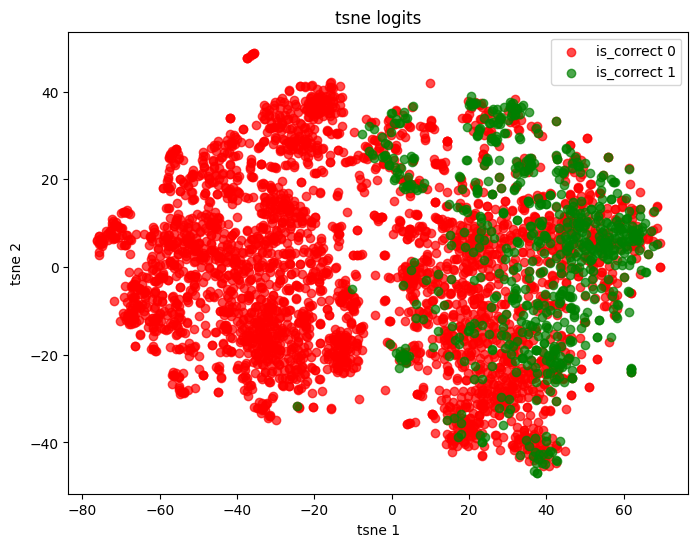

In [50]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## Unbalanced data + LogisticRegression

In [51]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [52]:
def y_proportion(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    total_elements = tensor.numel()
    proportions = counts.float() / total_elements
    return proportions

print(y_proportion(y))
print(y_proportion(y_train))
print(y_proportion(y_test))

tensor([0.8240, 0.1760])
tensor([0.8272, 0.1728])
tensor([0.8112, 0.1887])


In [53]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [54]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       649
           1       0.53      0.52      0.52       151

    accuracy                           0.82       800
   macro avg       0.71      0.71      0.71       800
weighted avg       0.82      0.82      0.82       800



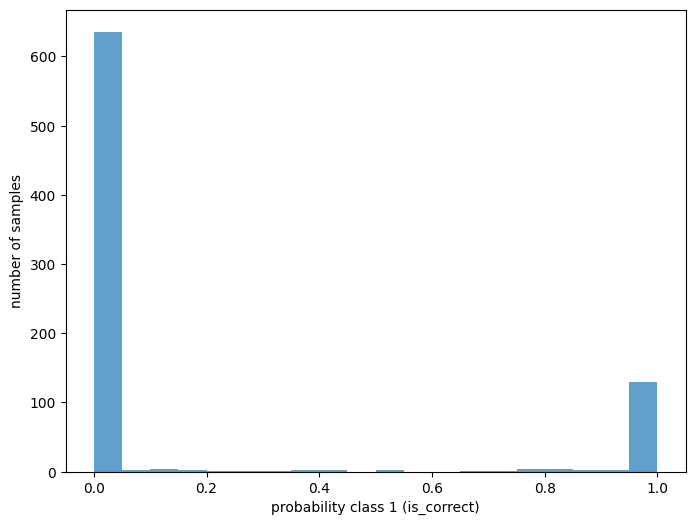

In [55]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [56]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_head_logits', rag_calls)

800it [00:00, 22003.77it/s]


## Downsampling + LogisticRegression

In [57]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

downsampled_class_0_indices = np.random.choice(class_0_indices, size=int(len(class_1_indices)*1.5), replace=False)
balanced_indices = np.concatenate([downsampled_class_0_indices, class_1_indices])
np.random.shuffle(balanced_indices)

X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [58]:
print('Before')
print(f'Num samples in train: {y_train.shape[0]}')
print(f'Distribution: {y_proportion(y_train)}')

print('After')
print(f'Num samples in train: {y_train_balanced.shape[0]}')
print(y_proportion(y_train_balanced))

Before
Num samples in train: 3200
Distribution: tensor([0.8272, 0.1728])
After
Num samples in train: 1382
tensor([0.5999, 0.4001])


In [59]:
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [60]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       649
           1       0.49      0.77      0.59       151

    accuracy                           0.80       800
   macro avg       0.71      0.79      0.73       800
weighted avg       0.85      0.80      0.82       800



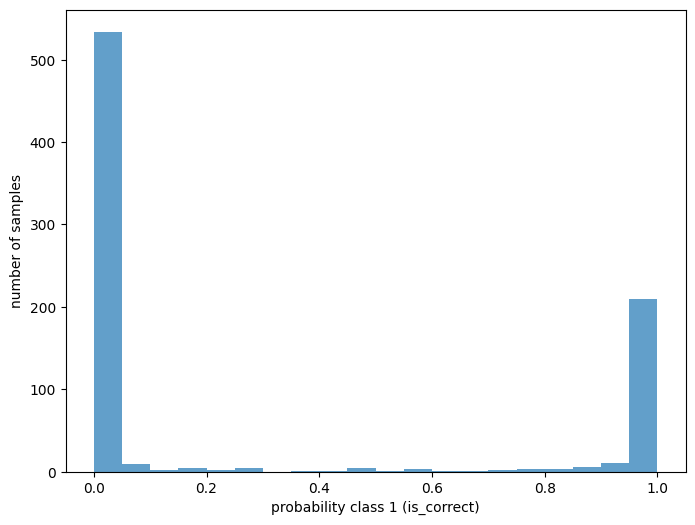

In [61]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [62]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_downsampling_head_logits', rag_calls)

800it [00:00, 22339.83it/s]


## MLP + bce + unbalanced data

In [63]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [64]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

y_train = y_train.float()
y_test = y_test.float()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{30}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.5608
Epoch 2/30, Loss: 0.2807
Epoch 3/30, Loss: 0.2283
Epoch 4/30, Loss: 0.2130
Epoch 5/30, Loss: 0.1954
Epoch 6/30, Loss: 0.1757
Epoch 7/30, Loss: 0.1725
Epoch 8/30, Loss: 0.1813
Epoch 9/30, Loss: 0.1626
Epoch 10/30, Loss: 0.1248
Epoch 11/30, Loss: 0.1020
Epoch 12/30, Loss: 0.0863
Epoch 13/30, Loss: 0.0932
Epoch 14/30, Loss: 0.0956
Epoch 15/30, Loss: 0.0681
Epoch 16/30, Loss: 0.0487
Epoch 17/30, Loss: 0.0386
Epoch 18/30, Loss: 0.0437
Epoch 19/30, Loss: 0.0313
Epoch 20/30, Loss: 0.0481
Epoch 21/30, Loss: 0.0300
Epoch 22/30, Loss: 0.0280
Epoch 23/30, Loss: 0.0268
Epoch 24/30, Loss: 0.0125
Epoch 25/30, Loss: 0.0099
Epoch 26/30, Loss: 0.0066
Epoch 27/30, Loss: 0.0060
Epoch 28/30, Loss: 0.0049
Epoch 29/30, Loss: 0.0038
Epoch 30/30, Loss: 0.0035


In [65]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0.5).astype(int)

print(classification_report(y_test.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       649
         1.0       0.57      0.61      0.59       151

    accuracy                           0.84       800
   macro avg       0.74      0.75      0.75       800
weighted avg       0.84      0.84      0.84       800



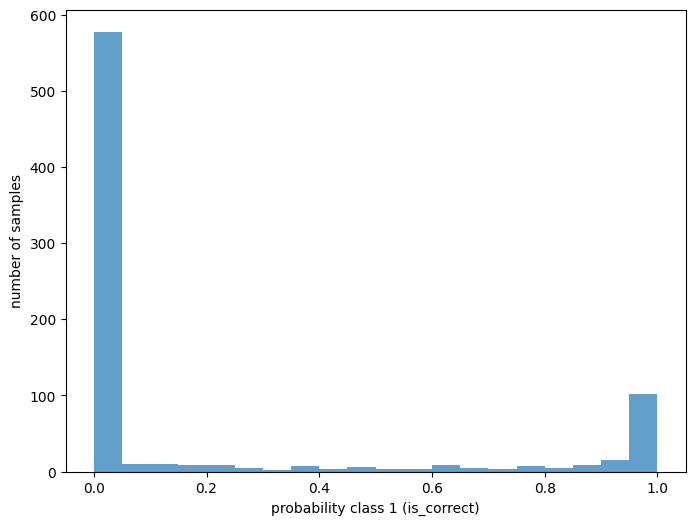

In [66]:
plt.figure(figsize=(8, 6))
plt.hist(logits_test, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [67]:
preds_df = call_rag(preds_df, y_pred, 'mlp_head_logits', rag_calls)

800it [00:00, 20122.72it/s]


# hook_resid_post 2 layer Logits 

In [88]:
def store_activations(activation_dict):
    def hook_fn(activation, hook):
        activation_dict[hook.name] = activation.detach()
    return hook_fn

In [89]:
X = torch.empty((ds.shape[0], 3072), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0
activation_store = {}

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        # (1, seq_len, vocab_size)
        logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store)) 
                for i in range(model.cfg.n_layers)],
        )
    resid = activation_store[f"blocks.{1}.hook_resid_post"] # last hidden_state before lm head (1, seq_len, hidden_size)
    final_logits = resid[:, -1, :].squeeze(dim=0) # (vocab_size)

    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [04:37<00:00, 14.41it/s]


In [90]:
print(X.shape)
print(y.shape)

torch.Size([4000, 3072])
torch.Size([4000])


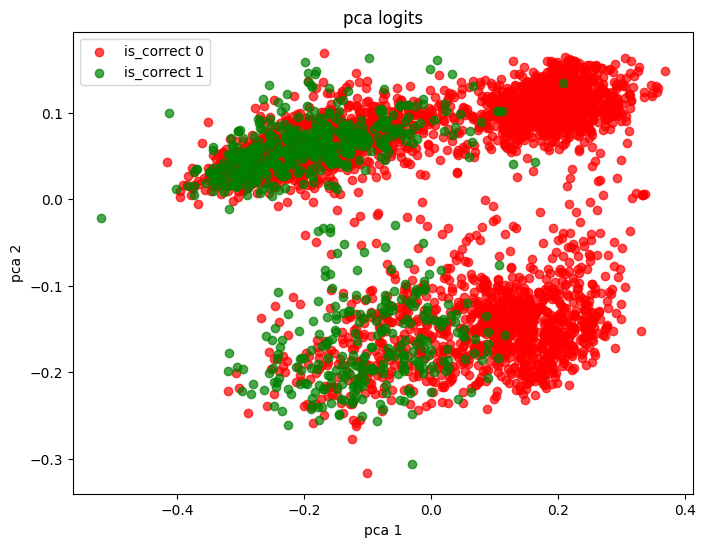

In [91]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

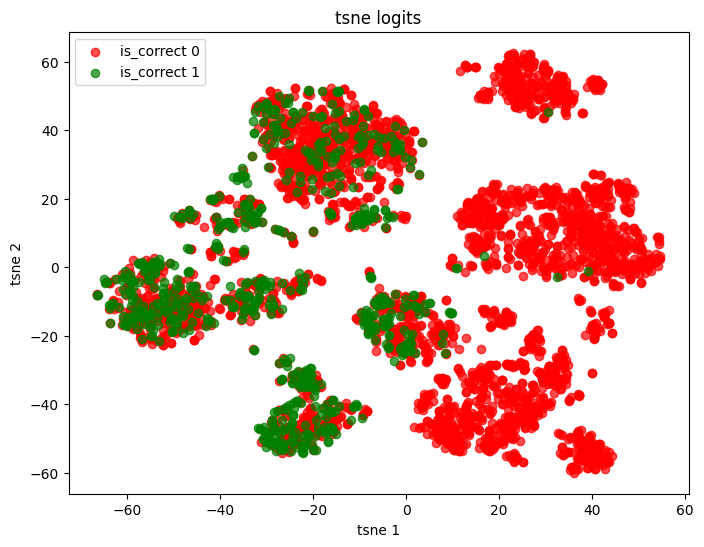

In [92]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## weighted bce MLP + unbalanced data

In [93]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [94]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [95]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [105]:
mlp = MLP().to(device)

class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

In [111]:
for epoch in range(1000):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    if epoch%20 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.3529
Epoch 21, Loss: 0.3535
Epoch 41, Loss: 0.3221
Epoch 61, Loss: 0.2918
Epoch 81, Loss: 0.2727
Epoch 101, Loss: 0.2480
Epoch 121, Loss: 0.2200
Epoch 141, Loss: 0.2113
Epoch 161, Loss: 0.1866
Epoch 181, Loss: 0.1590
Epoch 201, Loss: 0.1348
Epoch 221, Loss: 0.1293
Epoch 241, Loss: 0.1054
Epoch 261, Loss: 0.0884
Epoch 281, Loss: 0.1205
Epoch 301, Loss: 0.0850
Epoch 321, Loss: 0.0564
Epoch 341, Loss: 0.0522
Epoch 361, Loss: 0.0387
Epoch 381, Loss: 0.0314
Epoch 401, Loss: 0.0250
Epoch 421, Loss: 0.0207
Epoch 441, Loss: 0.0170
Epoch 461, Loss: 0.0146
Epoch 481, Loss: 0.0112
Epoch 501, Loss: 0.0088
Epoch 521, Loss: 0.0084
Epoch 541, Loss: 0.0087
Epoch 561, Loss: 0.0066
Epoch 581, Loss: 0.0053
Epoch 601, Loss: 0.0051
Epoch 621, Loss: 0.0036
Epoch 641, Loss: 0.0026
Epoch 661, Loss: 0.0022
Epoch 681, Loss: 0.0036
Epoch 701, Loss: 0.0027
Epoch 721, Loss: 0.0027
Epoch 741, Loss: 0.0020
Epoch 761, Loss: 0.0017
Epoch 781, Loss: 0.0013
Epoch 801, Loss: 0.0010
Epoch 821, Loss: 0.000

In [114]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device))
    y_pred = torch.argmax(logits_test, dim=1).cpu().numpy()

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       649
           1       0.46      0.47      0.47       151

    accuracy                           0.80       800
   macro avg       0.67      0.67      0.67       800
weighted avg       0.80      0.80      0.80       800



In [115]:
preds_df = call_rag(preds_df, y_pred, 'mlp_weighted_bce_loss_2_layer_resid_post_logits', rag_calls)

800it [00:00, 19714.82it/s]


# hook_attn_out 28 layer Logits

In [119]:
X = torch.empty((ds.shape[0], 3072), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0
activation_store = {}

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        # (1, seq_len, vocab_size)
        logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.hook_attn_out", store_activations(activation_store)) 
                for i in range(model.cfg.n_layers)],
        )
    resid = activation_store[f"blocks.{27}.hook_attn_out"] # last hidden_state before lm head (1, seq_len, hidden_size)
    final_logits = resid[:, -1, :].squeeze(dim=0) # (vocab_size)

    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [04:36<00:00, 14.48it/s]


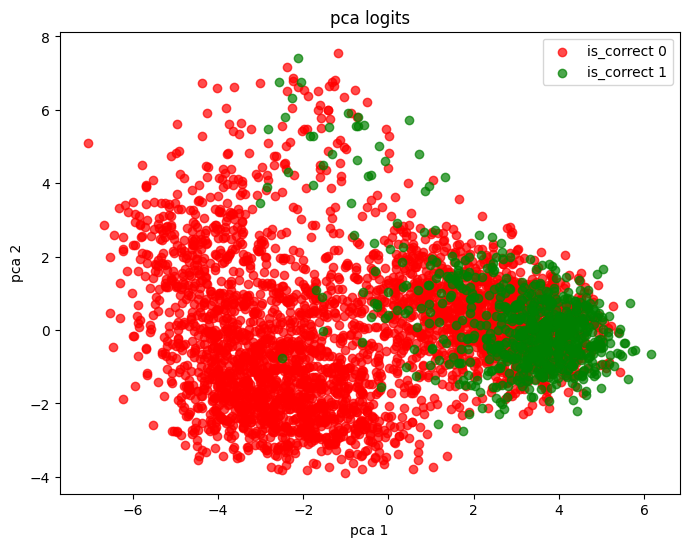

In [120]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

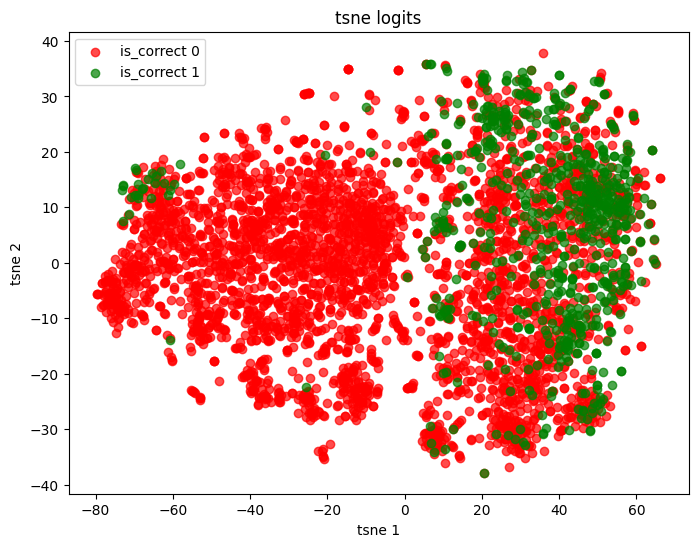

In [121]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## weighted bce MLP + unbalanced data

In [122]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [123]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [129]:
mlp = MLP().to(device)

class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

In [132]:
for epoch in range(100):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    if epoch%20 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.4102
Epoch 21, Loss: 0.3983
Epoch 41, Loss: 0.3833
Epoch 61, Loss: 0.3672
Epoch 81, Loss: 0.3587


In [133]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device))
    y_pred = torch.argmax(logits_test, dim=1).cpu().numpy()

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.24      0.37       649
           1       0.17      0.68      0.27       151

    accuracy                           0.32       800
   macro avg       0.47      0.46      0.32       800
weighted avg       0.65      0.32      0.35       800



In [134]:
preds_df = call_rag(preds_df, y_pred, 'mlp_weighted_bce_loss_28_layer_hook_attn_out_logits', rag_calls)

800it [00:00, 19723.86it/s]


# QA inference

In [116]:
def process_dataframe(df, pred_col, gt_col):
    has_answer_arr = []
    em_arr = []
    f1_arr = []
    
    for _, row in df.iterrows():
        prediction = row[pred_col]
        ground_truths = row[gt_col]

        has_ans = has_answer([ground_truths], prediction)
        em = EM_compute([ground_truths], prediction)
        f1 = F1_compute([ground_truths], prediction)
        
        has_answer_arr.append(has_ans)
        em_arr.append(em)
        f1_arr.append(f1)
    
    df['InAcc'] = has_answer_arr
    df['EM'] = em_arr
    df['F1'] = f1_arr
    
    mean_has_answer = np.mean(has_answer_arr) if has_answer_arr else 0
    mean_em = np.mean(em_arr) if em_arr else 0
    mean_f1 = np.mean(f1_arr) if f1_arr else 0

    return mean_has_answer, mean_em, mean_f1, df

In [135]:
rows = ["Never RAG", "Always RAG", "log_reg_head_logits", "log_reg_downsampling_head_logits", "mlp_head_logits", 'log_reg_28_layer_resid_post_logits', 'log_reg_downsampling_28_layer_resid_post_logits', 'mlp_28_layer_resid_post_logits', 'mlp_hinge_loss_28_layer_resid_post_logits', 'catboost_28_layer_resid_post_logits', 'mlp_weighted_bce_loss_28_layer_resid_post_logits', 'mlp_weighted_bce_loss_2_layer_resid_post_logits', 'mlp_weighted_bce_loss_28_layer_hook_attn_out_logits']
columns = ["F1", "Exact Match", "InAcc", "RAG calls"]
data = []

for row in rows:
    if row == "Never RAG":
        pred_col = 'our_answer_wo_context'
        rag_call_method = 'Never RAG'
    elif row == "Always RAG":
        pred_col = 'our_answer_w_context'
        rag_call_method = 'Always RAG'
    else:
        pred_col = row
        rag_call_method = row
        
    gt_col = 'reference'
   
    inacc_score, mean_em, mean_f1, _ = process_dataframe(preds_df, pred_col, gt_col)
    rag_call = rag_calls[rag_call_method]
    data.append([mean_f1, mean_em, inacc_score, rag_call])
    
metrics_df = pd.DataFrame(data, index=rows, columns=columns)

In [136]:
metrics_df

,F1,Exact Match,InAcc,RAG calls
Never RAG,0.143977,0.04125,0.14250,0
Always RAG,0.555243,0.36500,0.56875,800
log_reg_head_logits,0.516553,0.32250,0.52500,653
log_reg_downsampling_head_logits,0.475817,0.28250,0.48000,561
mlp_head_logits,0.514482,0.32125,0.52500,639
log_reg_28_layer_resid_post_logits,0.514578,0.32250,0.52750,654
log_reg_downsampling_28_layer_resid_post_logits,0.477648,0.29250,0.48000,550
mlp_28_layer_resid_post_logits,0.523548,0.32875,0.53375,664
mlp_hinge_loss_28_layer_resid_post_logits,0.509305,0.31625,0.52000,636
catboost_28_layer_resid_post_logits,0.535917,0.34750,0.54500,712
